# Final Project - Reinforcements Learning
Dear students,<br> this is the template notebook. Please copy it by clicking on the "File" tab and then on "Save a copy into drive".

---
<br>

### Name and ID:
Student 1: Ido Shenbach 318653789
<br>
Student 2: Yotam Peled 318847449
<br><br>
<img src="https://play-lh.googleusercontent.com/e_oKlKPISbgdzut1H9opevS7-LTB8-8lsmpCdMkhlnqFenZhpjxbLmx7l158-xQQCIY">

### https://github.com/mpSchrader/gym-sokoban

# Installs

In [45]:
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install gym
!pip install pygame
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install gym_sokoban
# !git clone https://github.com/avivg7/sokoban-so.git
# !unzip /content/sokoban-so/Compress.zip

# Imports

In [1]:
import numpy as np
import gym
from gym import logger as gymlogger
from gym.utils import seeding
from gym import error, spaces, utils
gymlogger.set_level(40) # error only
from soko_pap import *
import glob
import io
import base64
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pygame
import pyvirtualdisplay
import imageio
import IPython
import time

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

# Display utils
The cell below contains the video display configuration. No need to make changes here.

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

NameError: name 'pyvirtualdisplay' is not defined

Function - given an environment it will print us the details about observation, actions, agent's position and boxes locations

In [2]:
def print_env_det(env):
  print(f'Observation space: {env.observation_space}'
      f'\nAction space: {env.action_space}'
      f'\nPlayer position:{env.player_position}'
      f'\nBox location: {find_box_location(env)}')

Function - given an environment it will return the indexes position and boxes locations

In [3]:
def find_box_location(env):
    idx = np.argmax(env.room_state == 4)
    if env.room_state.flat[idx] == 4:
        return np.unravel_index(idx, env.room_state.shape)
    return None

# Feeling the Env

## EX1 - FIX SCENARIO -  PUSH & PULL - ONE BOX

In [4]:
#=============== DO NOT DELETE ===============
random.seed(2)
sok = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=1 ,max_steps=50)
# ============================================

In [4]:
# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## DDQN Architecture

In [5]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 1024)
        self.fc3 = nn.Linear(1024, 2048)
        self.fc4 = nn.Linear(2048, 2048)
        self.fc5 = nn.Linear(2048, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return 

## Train

In [59]:
# Hyperparameters
learning_rate = 0.00015
gamma = 0.95
epsilon_start = 1
epsilon_end = 0
epsilon_decay = 0.9995
batch_size = 128
memory_size = 3000
num_episodes = 10000

# Initialize DQN and target network
input_dim = 49 # 7x7 grid
output_dim = 4 # 4 possible actions

policy_net = DQN(input_dim, output_dim).to(device)
target_net = DQN(input_dim, output_dim).to(device)

policy_net.load_state_dict(torch.load("7X7-random-ddqn-push-only\ddqn-MEGAMASTERxPRO.pth"))
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
memory = deque(maxlen=memory_size)

def select_action(state, epsilon):
    rand = random.random()
    if rand < epsilon:
        return random.randrange(output_dim)
    else:
        with torch.no_grad():
            return policy_net(state).max(1)[1].item()

def optimize_model():
    if len(memory) < batch_size:
        return

    transitions = random.sample(memory, batch_size)
    batch = list(zip(*transitions))

    state_batch = torch.cat(batch[0])
    action_batch = torch.tensor(batch[1], device=device).unsqueeze(1)
    reward_batch = torch.tensor(batch[2], device=device)
    next_state_batch = torch.cat(batch[3])
    done_batch = torch.tensor(batch[4], dtype=torch.float32, device=device)

    current_q_values = policy_net(state_batch).gather(1, action_batch)

    with torch.no_grad():
        next_q_values = target_net(next_state_batch).max(1)[0]
    expected_q_values = reward_batch + gamma * next_q_values * (1 - done_batch)


    loss = nn.MSELoss()(current_q_values, expected_q_values.unsqueeze(1))
    loss_value = loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss_value

# Training loop
epsilon = epsilon_start
for episode in range(num_episodes):
    sok.reset()
    obs = sok.room_state
    state = torch.from_numpy(obs).float().flatten().unsqueeze(0).to(device)
    total_reward = 0
    done = False
    num_moves = 0
    running_loss = 0
    current_run_state_memory = [state]
    
    while not done:
        action = select_action(state, epsilon)
        obs, reward, done, _ = sok.step(action + 1) # action is 1-indexed
        obs = sok.room_state
        next_state = torch.from_numpy(obs).float().flatten().unsqueeze(0).to(device)

        if any(torch.equal(next_state, s) for s in current_run_state_memory):
            reward -= 1000
            done = True

        current_run_state_memory.append(next_state)
        total_reward += reward
        memory.append((state, action, reward, next_state, done))
        state = next_state

        current_loss_value = optimize_model()
        
        if current_loss_value is not None:
            running_loss += current_loss_value

    target_net.load_state_dict(policy_net.state_dict()) 
    epsilon = max(epsilon_end, epsilon * epsilon_decay)

    print(f"Episode: {episode}, Total Reward: {total_reward:.4f}, Epsilon: {epsilon}, Loss: {running_loss/sok.num_env_steps:.4f}")

Episode: 90000, Total Reward: 10.2000, Epsilon: 0, Loss: 0.0000
Episode: 90001, Total Reward: 10.4000, Epsilon: 0, Loss: 0.0000
Episode: 90002, Total Reward: 10.6000, Epsilon: 0, Loss: 0.0000
Episode: 90003, Total Reward: 10.6000, Epsilon: 0, Loss: 0.0000
Episode: 90004, Total Reward: 10.5000, Epsilon: 0, Loss: 0.0000
Episode: 90005, Total Reward: 9.8000, Epsilon: 0, Loss: 0.0000
Episode: 90006, Total Reward: 10.6000, Epsilon: 0, Loss: 0.0000
Episode: 90007, Total Reward: 10.4000, Epsilon: 0, Loss: 0.0000
Episode: 90008, Total Reward: 10.3000, Epsilon: 0, Loss: 0.0000
Episode: 90009, Total Reward: 10.7000, Epsilon: 0, Loss: 0.0000
Episode: 90010, Total Reward: 10.3000, Epsilon: 0, Loss: 0.0000
Episode: 90011, Total Reward: 10.8000, Epsilon: 0, Loss: 0.0000
Episode: 90012, Total Reward: 10.6000, Epsilon: 0, Loss: 0.0000
Episode: 90013, Total Reward: 10.9000, Epsilon: 0, Loss: 0.0000
Episode: 90014, Total Reward: 10.2000, Epsilon: 0, Loss: 0.0000
Episode: 90015, Total Reward: 10.4000, Ep

## Test on fixed room

In [6]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 1024)
        self.fc3 = nn.Linear(1024, 2048)
        self.fc4 = nn.Linear(2048, 2048)
        self.fc5 = nn.Linear(2048, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

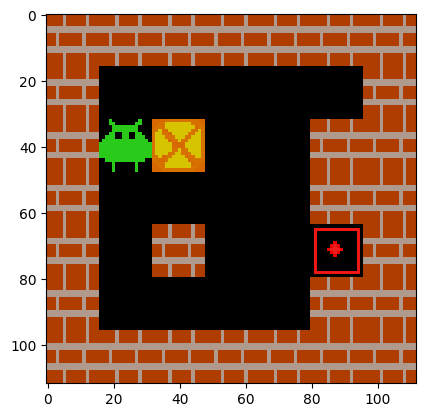

Final Reward: 10.1


In [64]:
# Load the model
input_dim = 49 # 7x7 grid
output_dim = 4 # 4 actions
policy_net = DQN(input_dim, output_dim).to(device)
policy_net.load_state_dict(torch.load("ddqn-MEGAMASTERxPRO.pth"))

random.seed(2)
sok = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=1 ,max_steps=20)

plt.imshow(sok.render('rgb_array'))
plt.show()

obs = sok.room_state
state = torch.from_numpy(obs).float().flatten().unsqueeze(0).to(device)
total_reward = 0
done = False

with torch.no_grad():
    while not done:
        action = policy_net(state).max(1)[1].item()
        obs, reward, done, _ = sok.step(action + 1) # action is 1-indexed
        next_state = torch.from_numpy(sok.room_state).float().flatten().unsqueeze(0).to(device)
        total_reward += reward
        state = next_state

print(f"Final Reward: {total_reward}")
sok.close()

Observation space: Box(0.0, 255.0, (112, 112, 3), float32)
Action space: Discrete(13)
Player position:[4 4]
Box location: None


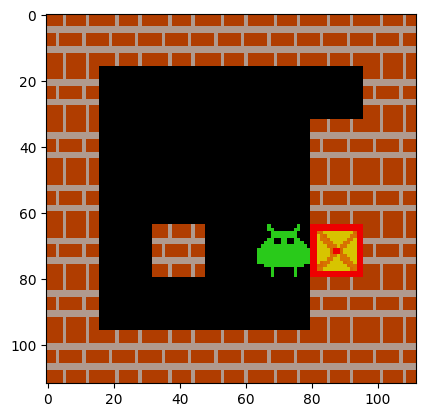

In [69]:
screen = sok.render(mode='rgb_array')
plt.imshow(sok.render('rgb_array'))
print_env_det(sok)

# Policy Gradient Architecture

In [ ]:
class PG(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PG, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 1024)
        self.fc3 = nn.Linear(1024, 2048)
        self.fc4 = nn.Linear(2048, 2048)
        self.fc5 = nn.Linear(2048, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return torch.softmax(x, dim=-1) # outputs probability distribution

In [ ]:
# Hyperparameters
learning_rate = 0.000015
gamma = 1
memory_size = 3000
num_episodes = 200000

# Initialize PG and target network
input_dim = 36  # 6x6 grid
output_dim = 4  # Number of actions

agent = PG(input_dim, output_dim).to(device)

optimizer = optim.Adam(agent.parameters(), lr=learning_rate)
memory = deque(maxlen=memory_size)

def select_action(state):
    # network returns a prob distribution over actions
    action_probs = agent(state)
    return torch.multinomial(action_probs, 1).item()

def optimize_model():
    # take all the transitions from memory
    state_batch = torch.cat([transition[0] for transition in memory])
    action_batch = torch.tensor([transition[1] for transition in memory], device=device).unsqueeze(1)
    reward_batch = torch.tensor([transition[2] for transition in memory], device=device)
    
    current_q_dist = agent(state_batch).gather(1, action_batch) # prob of action taken from a state

    # Compute R = r + gamma * rewar_batch[0] + gamma^2 * reward_batch[1] + ...
    R = torch.zeros(len(memory), device=device)
    for i in range(len(reward_batch)):
        R[i] = sum([gamma**j * reward_batch[j] for j in range(i, len(reward_batch))])

    loss = -torch.sum(torch.log(current_q_dist) * R) # negative because we want to maximize R

    loss_value = loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss_value

# Training loop
for episode in range(num_episodes):
    print(f"Episode {episode} of {num_episodes}", end="\r")
    sok.reset()
    obs = sok.room_state
    state = torch.from_numpy(obs).float().flatten().unsqueeze(0).to(device)
    total_reward = 0
    done = False

    while not done:
        action = select_action(state)
        obs, reward, done, _ = sok.step(action + 1) # action is 1-indexed
        obs = sok.room_state
        next_state = torch.from_numpy(obs).float().flatten().unsqueeze(0).to(device)
        total_reward += reward
        memory.append((state, action, reward))
        state = next_state

    current_loss_value = optimize_model()
    memory.clear()

    print(f"Episode: {episode}, Total Reward: {total_reward:.1f}, Loss: {current_loss_value}")


### EX1 - Video test

In [ ]:
env = sok
start_time = time.time()
done = False
iter = 0
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=10) as video:
  while (iter < 10) or not done:
    time_passed = int(time.time() - start_time)
    if done or time_passed > 3:
      break
    iter +=1
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    video.append_data(env.render(mode='rgb_array'))
embed_mp4(video_filename)

## EX2 - PUSH & PULL - ONE BOX

In [8]:
#=============== DO NOT DELETE ===============
sok_2 = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=1 ,max_steps=500)
# ============================================

## Test on 1000 episodes

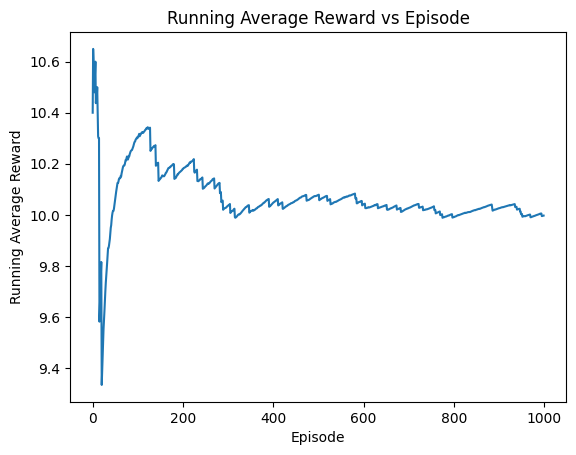

In [76]:
# Load the model
input_dim = 49
output_dim = 4
policy_net = DQN(input_dim, output_dim).to(device)
policy_net.load_state_dict(torch.load("ddqn-MEGAMASTERxPRO.pth"))

reward_memory = []
with torch.no_grad():
    for i in range(1, 1001):
        print(f"Episode: {i}", end="\r")
        total_reward = 0
        done = False
        sok_2.reset()
        state = torch.from_numpy(sok_2.room_state).float().flatten().unsqueeze(0).to(device)
    
        current_run_state_memory = [state]
        while not done:
            action = policy_net(state).max(1)[1].item()
            obs, reward, done, _ = sok_2.step(action + 1)
            next_state = torch.from_numpy(sok_2.room_state).float().flatten().unsqueeze(0).to(device)
            total_reward += reward

            if any(torch.equal(next_state, s) for s in current_run_state_memory):
                done = True
            
            current_run_state_memory.append(next_state)
            
            state = next_state
        
        reward_memory.append(total_reward)
    
# compute the running average of the total rewards
running_average_reward = []
for index, reward in enumerate(reward_memory, 1):
    running_average_reward.append(np.mean(reward_memory[:index]))

plt.plot(running_average_reward)
plt.xlabel("Episode")
plt.ylabel("Running Average Reward")
plt.title("Running Average Reward vs Episode")
plt.show()
sok.close()

Observation space: Box(0.0, 255.0, (112, 112, 3), float32)
Action space: Discrete(13)
Player position:[3 2]
Box location: (2, 2)


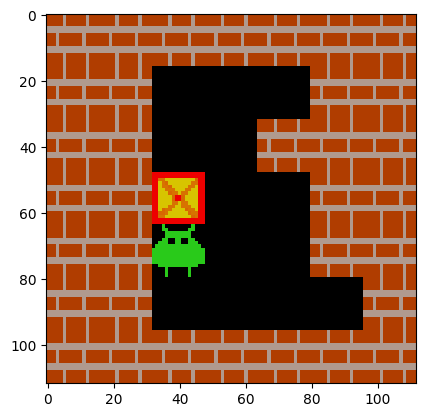

In [77]:
screen = sok_2.render(mode='rgb_array')
plt.imshow(sok_2.render('rgb_array'))
observation, reward, done, _ = sok_2.step(1)
print_env_det(sok_2)

### EX2 - Video test

In [ ]:
env = sok_2
start_time = time.time()
done = False
iter = 0
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=10) as video:
  while (iter < 10) or not done:
    time_passed = int(time.time() - start_time)
    if done or time_passed > 3:
      break
    iter +=1
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    video.append_data(env.render(mode='rgb_array'))
embed_mp4(video_filename)

## EX3 - PUSH & PULL - TWO BOXES

In [ ]:
#=============== DO NOT DELETE ===============
sok_3 = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=2 ,max_steps=500)
# ============================================

Observation space: Box(0.0, 255.0, (112, 112, 3), float32)
Action space: Discrete(13)
Player position:[5 1]
Box mapping: {(1, 1): (4, 1), (3, 2): (4, 2)}


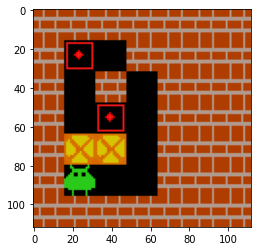

In [ ]:
screen = sok_3.render(mode='rgb_array')
plt.imshow(sok_3.render('rgb_array'))
print_env_det(sok_3)

### EX3 - Video test

In [ ]:
env = sok_3
start_time = time.time()
done = False
iter = 0
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=10) as video:
  while (iter < 10) or not done:
    time_passed = int(time.time() - start_time)
    if done or time_passed > 3:
      break
    iter +=1
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    video.append_data(env.render(mode='rgb_array'))
embed_mp4(video_filename)